In [1]:
import tensorflow as tf
import pathlib
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data_dir = "frames"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

test_data_dir = "test_frames"
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(test_image_count)

BATCH_SIZE = 32
IMG_HEIGHT = 720//2
IMG_WIDTH = 1280//2
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(test_image_count/BATCH_SIZE)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

24620
4406


Found 24620 images belonging to 8 classes.
Found 4406 images belonging to 1 classes.


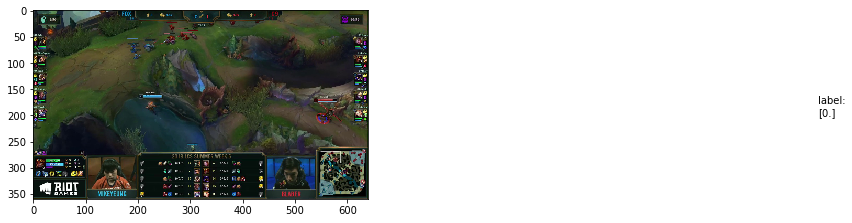

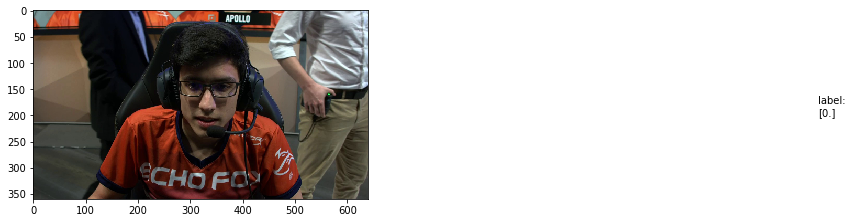

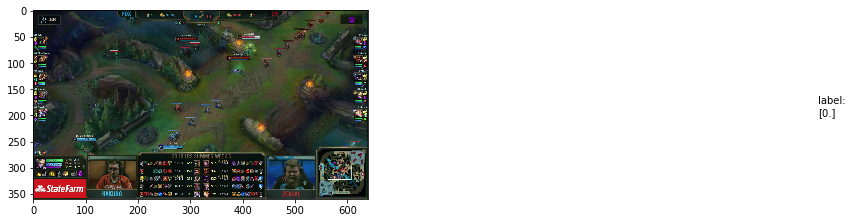

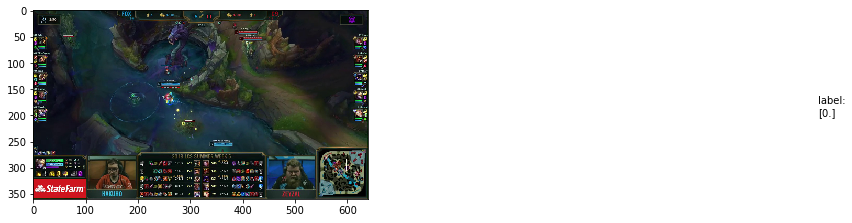

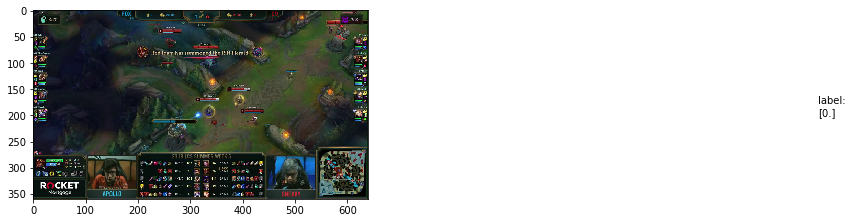

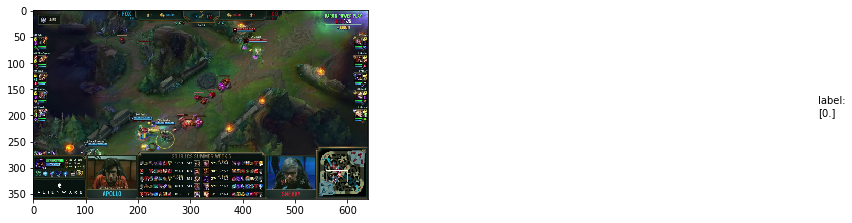

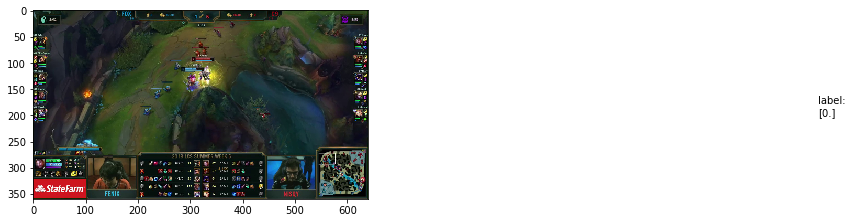

In [ ]:
def label_map(datagen):
    for x in datagen:
        
        # Get the filenames that are shuffled
        current_index = ((datagen.batch_index-1) * datagen.batch_size)
        if current_index < 0:
            if datagen.samples % datagen.batch_size > 0:
                current_index = max(0,datagen.samples - datagen.samples % datagen.batch_size)
            else:
                current_index = max(0,datagen.samples - datagen.batch_size)
        index_array = datagen.index_array[current_index:current_index + datagen.batch_size].tolist()
        img_paths = [datagen.filepaths[idx] for idx in index_array]
        y = []
        for f in img_paths:
#             print(f)
            label = np.zeros(1)
            if "-h" in f:
                label[0] = 1
            y.append(label)
        yield x, np.array(y)

train_data_gen = train_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)
train_data_gen = label_map(train_data_gen)

test_data_gen = train_image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)
test_data_gen = label_map(test_data_gen)

data, labels = next(test_data_gen)
# print(labels)
for i in range(len(data)):
    plt.figure()
    plt.imshow(data[i])
    plt.text(1500,200,"label:\n" + str(labels[i]))

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 638, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 319, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 179, 319, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 317, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 158, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 88, 158, 64)       0         
_________________________________________

In [ ]:
mc = ModelCheckpoint('models/best_non_seq_model_seg.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss=K.binary_crossentropy, 
              optimizer='adam',
              metrics=[])

history = model.fit_generator(train_data_gen, 
                    epochs=20, 
                    validation_data=test_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[mc],
                    use_multiprocessing=True,
                    workers=2,
                   )